In [26]:
from copy import deepcopy
import numpy as np
import time

from sklearn.utils import shuffle

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_accuracy, central_loss, best_accuracy
from network import graph
from optimization import centralized_FW, regularized_local_FW, local_FW, async_regularized_local_FW, global_regularized_local_FW, gd_reg_local_FW
from related_works import colearning, lafond_FW
from utils import load_mobiact, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
# set graph of nodes with local personalized data
NB_ITER = 200
MU = 0.001
BETA = 10

X, Y, X_test, Y_test, adjacency, similarities, nb_nodes = load_mobiact("../datasets/")

D = X[0].shape[1]
B = 5*D
# set graph
nodes = graph(X, Y, X_test, Y_test, nb_nodes, adjacency, similarities)

# set callbacks for optimization analysis
callbacks = {
    'accuracy': [central_accuracy, []],
    'loss': [central_loss, []]
}

results = {}

vmin, vmax = get_min_max(X)
base_clfs = get_stumps(B, D+1, vmin, vmax)

In [28]:
nodes_centralized = deepcopy(nodes)
results["centralized"] = centralized_FW(nodes_centralized, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)

nodes_regularized = deepcopy(nodes)
t1 = time.time()
results["regularized"] = regularized_local_FW(nodes_regularized, base_clfs, beta=BETA, nb_iter=NB_ITER, mu=MU, callbacks=callbacks)
t2 = time.time()

local_nodes = deepcopy(nodes)
results["local"] = local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)

lafond_nodes = deepcopy(nodes)
t3 = time.time()
results["lafond"] = lafond_FW(lafond_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, callbacks=callbacks)
t4 = time.time()

# colearning results
# results["colearning"], clf_colearning = colearning(nb_nodes, X, Y, X_test, Y_test, D, NB_ITER, adjacency, similarities)

# gd_nodes = deepcopy(nodes)
# results["gd-regularized"] = gd_reg_local_FW(gd_nodes, base_clfs, pace_gd=10, beta=BETA, nb_iter=NB_ITER, mu=MU, callbacks=callbacks)

# get best accuracy on train and test samples
gb_train_acc, gb_test_acc = best_accuracy(nodes)

regularized: total time 104.77780079841614
lafond: total time 156.76646900177002


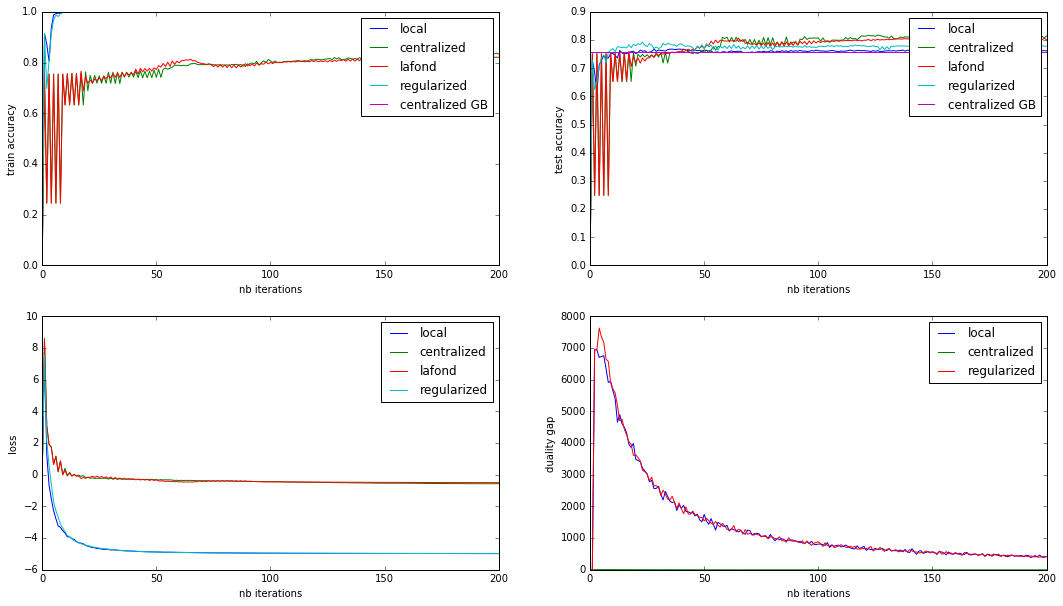

In [29]:
plt.figure(1, figsize=(18, 10))

plt.subplot(221)
plt.xlabel('nb iterations')
plt.ylabel('train accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][0] for r in r_list], label='{}'.format(k))
plt.plot(range(len(r_list)), [gb_train_acc]*len(r_list), label='centralized GB')

plt.legend()

plt.subplot(222)
plt.xlabel('nb iterations')
plt.ylabel('test accuracy')

for k, r_list in results.items():
    plt.plot(range(len(r_list)), [r['accuracy'][1] for r in r_list], label='{}'.format(k))
plt.plot(range(len(r_list)), [gb_test_acc]*len(r_list), label='centralized GB')

plt.legend()

plt.subplot(223)
plt.xlabel('nb iterations')
plt.ylabel('loss')

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [r['loss'] for r in r_list], label='{}'.format(k))
    except:
        pass

plt.legend()

plt.subplot(224)
plt.xlabel('nb iterations')
plt.ylabel('duality gap')

for k, r_list in results.items():
    try:
        plt.plot(range(len(r_list)), [r['duality-gap'] for r in r_list], label='{}'.format(k))
    except:
        pass

plt.legend()

print("regularized: total time", t2-t1)
print("lafond: total time", t4-t3)